In [ ]:
from benchmarklib.databases import CliqueDatabase
from benchmarklib import setup_logging, BenchmarkDatabase

import logging

from clique import CliqueProblem, CliqueTrial
setup_logging(logging.DEBUG)

In [ ]:
#clique_db = CliqueDatabase(db_path="/home/nels/dev/python/tweedledum-research/Python2QCCompiler/benchmarklib/shared/problems/clique.db")
clique_db = BenchmarkDatabase("clique.db", )

[[0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]

[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]

[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]



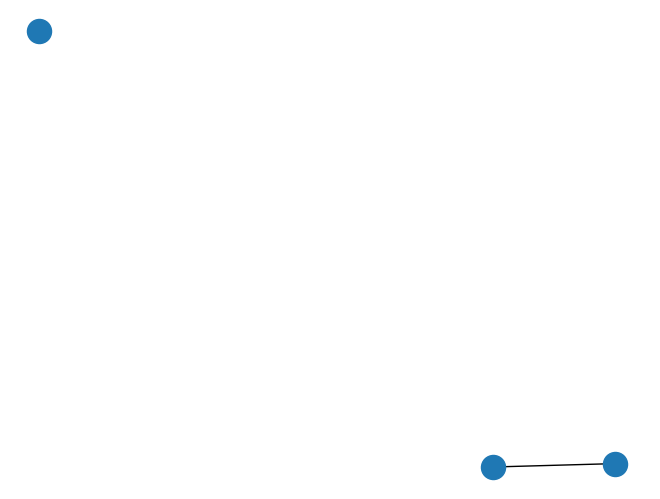

In [12]:
from IPython.display import display
import networkx as nx

problems = clique_db.random_sample(limit=3, n=3, p=50)

for p in problems:
    print(p.as_adjacency_matrix(), end="\n\n")


p = problems[0]

G = nx.from_numpy_array(p.as_adjacency_matrix())
nx.draw(G)


# [[0. 1. 1. 1. 0. 0.]
#  [1. 0. 1. 1. 0. 1.]
#  [1. 1. 0. 0. 0. 0.]
#  [1. 1. 0. 0. 0. 0.]
#  [0. 0. 0. 0. 0. 0.]
#  [0. 1. 0. 0. 0. 0.]]

# Compilers

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
from dotenv import load_dotenv
import os

# create XAG Compiler

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_cloud", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")


In [5]:
from benchmarklib.pipeline import PipelineCompiler, QiskitTranspile
from benchmarklib.pipeline.synthesis import XAGSynthesizer, TruthTableSynthesizer, ClassiqSynthesizer, QuantumMPC

# compiler is defined by a synthesizer and a series of steps
compiler_xag = PipelineCompiler(
    synthesizer = XAGSynthesizer(),
    # Transpilation is an optional step, but passing a backend & transpile options will do it automatically
    #steps = [QiskitTranspile(backend=backend, optimization_level=3)]
    steps = [], 
    backend = backend, 
    transpile_options = {"optimization_level": 3}
)

compiler_tt = PipelineCompiler(
    synthesizer = TruthTableSynthesizer(),
    steps=[],
    backend = backend, 
    transpile_options = {"optimization_level": 3}
)

# compiler is defined by a synthesizer and a series of steps
compiler_qmpc = PipelineCompiler(
    synthesizer = QuantumMPC(),
    # Transpilation is an optional step, but passing a backend & transpile options will do it automatically
    #steps = [QiskitTranspile(backend=backend, optimization_level=3)]
    steps = [], 
    backend = backend, 
    transpile_options = {"optimization_level": 3}
)


In [6]:
from pprint import pprint 

p = problems[0]
result_xag = compiler_xag.compile(problem=p, return_intermediate=True, clique_size=2)
pprint(result_xag)
result_xag.synthesis_circuit.draw('mpl')

#result_tt = compiler_tt.compile(problem=p, return_intermediate=True, clique_size=6)

# ensure you are authenticated for classiq
#result_classiq = compiler_classiq.compile(problem=p, return_intermediate=True, clique_size=3)

#print("Truth Table Success: ", result_tt.success)
#print("Classiq Success:", result_tt.success)

print(result_xag.artifacts["source"])

benchmarklib.pipeline.synthesis.xag - DEBUG - Optimizing XAG...
benchmarklib.pipeline.synthesis.xag - DEBUG - Outputting XAG to tempfile /tmp/tmpth52kjnl
benchmarklib.pipeline.synthesis.xag - DEBUG - b'digraph {\nrankdir=BT;\n0 [label="0",shape=box,style=filled,fillcolor=snow2]\n1 [label="1",shape=triangle,style=filled,fillcolor=snow2]\n2 [label="2",shape=triangle,style=filled,fillcolor=snow2]\n3 [label="3",shape=triangle,style=filled,fillcolor=snow2]\n4 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n5 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\npo0 [shape=invtriangle,style=filled,fillcolor=snow2]\n1 -> 4 [style=dashed]\n3 -> 4 [style=solid]\n2 -> 5 [style=solid]\n4 -> 5 [style=solid]\n5 -> po0 [style=solid]\n{rank = same; 0; 1; 2; 3; }\n{rank = same; 4; }\n{rank = same; 5; }\n{rank = same; po0; }\n}\n'
benchmarklib.pipeline.synthesis.xag - DEBUG - Synthesizing from XAG...
benchmarklib.pipeline.synthesis.xag - DEBUG - Applying optimization passes...


0
1
0
2
0
1
1
2
2
CompilationResult(compiler_name='XAGSynthesizer',
                  success=True,
                  total_time=0.9370684623718262,
                  synthesis_metrics=CircuitMetrics(num_qubits=5,
                                                   depth=5,
                                                   gate_count=7,
                                                   entangling_count=3,
                                                   single_qubit_count=4,
                                                   ops=OrderedDict([('x', 2),
                                                                    ('h', 2),
                                                                    ('ccrx_o2',
                                                                     2),
                                                                    ('ccx',
                                                                     1)]),
                                                   extra_

In [7]:
import ast

def string_to_python_code_obj(source:str, function_name:str):
    #Take linear, and remove the function definition and replace it with our own 
    function_header = "def clique_oracle_classical(vertices: list[bool]) -> bool:"
    new_source = str(source).split('\n')[1:]
    new_source.insert(0, function_header)

    new_source = "\n".join(new_source)
    new_source = new_source.replace('BitVec(1, 1)', 'True')
    new_source = new_source.replace('BitVec(1, 0)', 'False')

    func_ast = ast.parse(new_source)

    code_obj = compile(func_ast, function_name, mode="exec")

    exec(code_obj, globals())
    return new_source

string_to_python_code_obj(result_xag.artifacts["source"], "classical_clique_oracle")

'def clique_oracle_classical(vertices: list[bool]) -> bool:\n    """Counts cliques of size 2 in a graph specified by the edge list."""\n    s = True\n    s = s & ~(vertices[0] & vertices[1])\n    s = s & ~(vertices[0] & vertices[2])\n    s_0_0 = True\n    s_0_1 = False\n    s_0_2 = False\n    s_1_0 = True\n    s_1_1 = s_0_1 | vertices[0] & s_0_0\n    s_1_2 = False\n    s_2_0 = True\n    s_2_1 = s_1_1 | vertices[1] & s_1_0\n    s_2_2 = s_1_2 | vertices[1] & s_1_1\n    s_3_0 = True\n    s_3_1 = s_2_1 | vertices[2] & s_2_0\n    s_3_2 = s_2_2 | vertices[2] & s_2_1\n    at_least_k = s_3_2\n    return s & at_least_k'

In [8]:
# compiler is defined by a synthesizer and a series of steps
compiler_qmpc = PipelineCompiler(
    synthesizer = QuantumMPC(),
    # Transpilation is an optional step, but passing a backend & transpile options will do it automatically
    #steps = [QiskitTranspile(backend=backend, optimization_level=3)]
    steps = [], 
    backend = backend, 
    transpile_options = {"optimization_level": 3}
)

benchmarklib.pipeline.synthesis.qmpc - ERROR - /home/nels/Sync/tweedledum-research/QuantumCompilerMPC/quantum_benchmarks/clique_verifier.constants
benchmarklib.pipeline.synthesis.qmpc - DEBUG - INPUT FILE CONTENTS:
benchmarklib.pipeline.synthesis.qmpc - DEBUG - N!0=3
benchmarklib.pipeline.synthesis.qmpc - DEBUG - K!0=2
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Edges!0=[False, False, False, False, False, True, False, True, False]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Restricted AST:
benchmarklib.pipeline.synthesis.qmpc - DEBUG - def clique_verifier(Vertices: shared[list[bool; ?]], Edges: plaintext[list[bool; ?]], N: plaintext[int], K: plaintext[int]) -> shared[bool]:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count = 0
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     for i: plaintext[int] in range(0, N):
benchmarklib.pipeline.synthesis.qmpc - DEBUG -         if Vertices[i]:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -             count = (count + 1)
benchmarkli

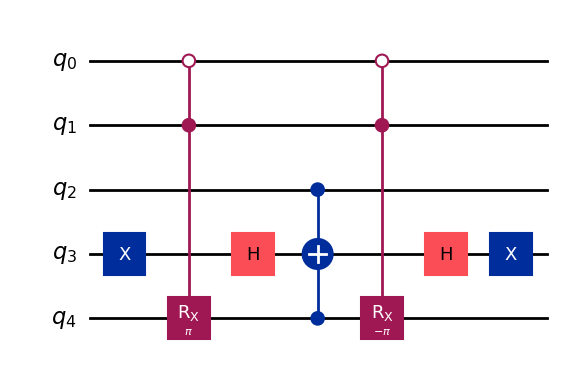

In [ ]:
result_qmpc = compiler_qmpc.compile(problem=p, return_intermediate=True, clique_size=2)
#pprint(result_qmpc)
result_qmpc.synthesis_circuit.draw('mpl')
#print(result_qmpc.artifacts["classical_verifier"])


In [15]:
import itertools


# Constants for the problem
N = 3 # Total number of vertices (V0 to V5)
K = 2 # Required clique size

def find_cliques(f, N, K):
    """Iterates over all 2^N subsets of vertices and prints the subsets 
       that the verifier confirms are K-cliques."""
    
    print(f"--- Clique Verifier Test (N={N}, K={K}) ---")
    print(f"Iterating over all 2^{N} = {2**N} vertex subsets...\n")
    
    # Generate all possible combinations of 6 booleans (representing V0 to V5 selection)
    all_subsets = list(itertools.product([False, True], repeat=N))
    
    found_cliques = []
    
    # Unused placeholder for the function, as the edges are hardcoded internally
    # in the verifier's logic.
    Edges_placeholder = [] 

    for subset in all_subsets:
        # Convert tuple to list for type hinting consistency
        Vertices = list(subset) 
        
        # Call the generated verifier function
        is_clique = f(Vertices)
        
        if is_clique:
            # Map the boolean list to vertex indices (0-based) for clarity
            selected_vertices = [i for i, selected in enumerate(Vertices) if selected]
            
            # Sanity check: verify the size is indeed K
            if len(selected_vertices) == K:
                 found_cliques.append(selected_vertices)
                 print(f"✅ FOUND {K}-CLIQUE: {selected_vertices}")
            else:
                 # This path shouldn't be reached if the verifier's K check is correct
                 print(f"⚠️ Verifier returned True for size {len(selected_vertices)}: {selected_vertices}")
    
    print("\n--- Summary ---")
    if found_cliques:
        print(f"Total verified {K}-cliques found: {len(found_cliques)}")
        print(f"List of {K}-cliques: {found_cliques}")
    else:
        print(f"No {K}-cliques were found by the verifier.")

    return found_cliques


In [16]:
find_cliques(result_qmpc.artifacts["classical_verifier"], N, K)
#find_cliques(clique_oracle_classical, N, K)

--- Clique Verifier Test (N=3, K=2) ---
Iterating over all 2^3 = 8 vertex subsets...

✅ FOUND 2-CLIQUE: [1, 2]

--- Summary ---
Total verified 2-cliques found: 1
List of 2-cliques: [[1, 2]]


[[1, 2]]

In [ ]:
def string_to_python_code_obj(source:str, function_name:str):
    #Take linear, and remove the function definition and replace it with our own 
    function_header = "def clique_oracle_classical(vertices: list[bool]) -> bool:"
    new_source = str(source).split('\n')[1:]
    new_source.insert(0, function_header)

    new_source = "\n".join(new_source)
    new_source = new_source.replace('BitVec(1, 1)', 'True')
    new_source = new_source.replace('BitVec(1, 0)', 'False')

    func_ast = ast.parse(new_source)

    code_obj = compile(func_ast, function_name, mode="exec")

    exec(code_obj, globals())
    return new_source


In [ ]:
# find_cliques_oracle()
string_to_python_code_obj(result_xag.artifacts['source'], "classical_oracle")

'def clique_oracle_classical(vertices: list[bool]) -> bool:\n    """Counts cliques of size 2 in a graph specified by the edge list."""\n    s = True\n    s = s & ~(vertices[0] & vertices[1])\n    s = s & ~(vertices[0] & vertices[2])\n    s = s & ~(vertices[1] & vertices[2])\n    s_0_0 = True\n    s_0_1 = False\n    s_0_2 = False\n    s_1_0 = True\n    s_1_1 = s_0_1 | vertices[0] & s_0_0\n    s_1_2 = False\n    s_2_0 = True\n    s_2_1 = s_1_1 | vertices[1] & s_1_0\n    s_2_2 = s_1_2 | vertices[1] & s_1_1\n    s_3_0 = True\n    s_3_1 = s_2_1 | vertices[2] & s_2_0\n    s_3_2 = s_2_2 | vertices[2] & s_2_1\n    at_least_k = s_3_2\n    return s & at_least_k'

In [24]:
from math import ceil

# Constants for the problem
N = 4 # Total number of vertices (V0 to V5)
# K = 3 # Required clique size

results= dict()


problems = clique_db.random_sample(limit=10, n=N, p=30)

for i, p in enumerate(problems):
    # compile both problems
    K = ceil(N/2)
    result_xag = compiler_xag.compile(problem=p, return_intermediate=True, clique_size=K)
    result_qmpc = compiler_qmpc.compile(problem=p, return_intermediate=True, clique_size=K)

    # extract classical functions 
    # creates clique_oracle_classical function for (N, ceil(N/2))
    string_to_python_code_obj(result_xag.artifacts["source"], "classical_clique_oracle")
    oracle_classical = clique_oracle_classical
    # qmpc classical function object lives in compiler_qmpc artifacts
    qmpc_classical_verifier = result_qmpc.artifacts['classical_verifier']

    # for each classical verfier, run on all inputs
    qmpc_found_cliques = find_cliques(qmpc_classical_verifier, N, K)
    oracle_found_cliques = find_cliques(oracle_classical, N, K)

    # standardize format
    qmpc_solution_set = {tuple(sorted(solution)) for solution in qmpc_found_cliques}
    oracle_solution_set = {tuple(sorted(solution)) for solution in oracle_found_cliques}

    # Solutions that were *found* but should *not* have been (False Positives/Extra)
    extra_solutions = qmpc_solution_set - oracle_solution_set
    
    # Solutions that should have been in the *ground truth* but were *not found* (False Negatives/Missing)
    missing_solutions = oracle_solution_set - qmpc_solution_set
    
    # Solutions found in both
    common_solutions = qmpc_solution_set.intersection(oracle_solution_set)
    
    results[i] = {
        "input": p.as_adjacency_matrix(),
        "results_dict_qmpc": result_qmpc,
        "results_dict_oracle": result_xag,
        "extra": [list(t) for t in extra_solutions],
        "missing": [list(t) for t in missing_solutions],
        "common": [list(t) for t in common_solutions],
        "match": not extra_solutions and not missing_solutions
    }





    

benchmarklib.pipeline.synthesis.xag - DEBUG - Optimizing XAG...
benchmarklib.pipeline.synthesis.xag - DEBUG - Outputting XAG to tempfile /tmp/tmp7leycufu
benchmarklib.pipeline.synthesis.xag - DEBUG - b'digraph {\nrankdir=BT;\n0 [label="0",shape=box,style=filled,fillcolor=snow2]\n1 [label="1",shape=triangle,style=filled,fillcolor=snow2]\n2 [label="2",shape=triangle,style=filled,fillcolor=snow2]\n3 [label="3",shape=triangle,style=filled,fillcolor=snow2]\n4 [label="4",shape=triangle,style=filled,fillcolor=snow2]\n5 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n6 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n7 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n8 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n9 [label="XOR",shape=ellipse,style=filled,fillcolor=lightskyblue]\n10 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n11 [label="XOR",shape=ellipse,style=filled,fillcolor=lightskyblue]\n12 [label="XOR",shape=e

0
1
0
2
0
3
1
2
1
3
2
3
0
1
1
2
2
3
3


benchmarklib.pipeline.synthesis.qmpc - DEBUG -             clique!5 = MUX(!2!3, clique!4, clique!3)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     !3!1 = (count!2 == K!0)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!2 = False
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!3 = MUX(!3!1, clique!2, result!2)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     return result!3
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Common subexpression elimination:
benchmarklib.pipeline.synthesis.qmpc - DEBUG - def clique_verifier(Vertices!0: shared[list[bool; ?]], Edges!0: plaintext[list[bool; ?]], N!0: plaintext[int], K!0: plaintext[int]) -> shared[bool]:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count!1 = 0
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     for i!1 in range(0, N!0):
benchmarklib.pipeline.synthesis.qmpc - DEBUG -         count!2 = Φ(count!1, count!4)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -         !1!2 = Vertices!0[i!1]
benchmarklib.pipel

--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...


--- Summary ---
No 2-cliques were found by the verifier.
--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...


--- Summary ---
No 2-cliques were found by the verifier.
0
1
0
2
0
3
2
3
0
1
1
2
2
3
3


benchmarklib.pipeline.synthesis.qmpc - DEBUG -     return result!3
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Forward edges:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter Vertices!0  →  parameter Vertices!0
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter Vertices!0  →  !1!2 = Vertices!0[i!1]
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter Vertices!0  →  !2!3 = (Vertices!0[i!2] and Vertices!0[j!1])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter Edges!0  →  parameter Edges!0
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter Edges!0  →  clique!4 = (clique!3 and Edges!0[((i!2 * N!0) + j!1)])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter N!0  →  parameter N!0
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter N!0  →  clique!4 = (clique!3 and Edges!0[((i!2 * N!0) + j!1)])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter K!0  →  parameter K!0
benchmarklib.pipeline.synthesis.qmpc - DEBUG 

--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [1, 3]
✅ FOUND 2-CLIQUE: [1, 2]

--- Summary ---
Total verified 2-cliques found: 2
List of 2-cliques: [[1, 3], [1, 2]]
--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [1, 3]
✅ FOUND 2-CLIQUE: [1, 2]

--- Summary ---
Total verified 2-cliques found: 2
List of 2-cliques: [[1, 3], [1, 2]]


benchmarklib.pipeline.synthesis.xag - DEBUG - Optimizing XAG...
benchmarklib.pipeline.synthesis.xag - DEBUG - Outputting XAG to tempfile /tmp/tmpxi9ny0ae
benchmarklib.pipeline.synthesis.xag - DEBUG - b'digraph {\nrankdir=BT;\n0 [label="0",shape=box,style=filled,fillcolor=snow2]\n1 [label="1",shape=triangle,style=filled,fillcolor=snow2]\n2 [label="2",shape=triangle,style=filled,fillcolor=snow2]\n3 [label="3",shape=triangle,style=filled,fillcolor=snow2]\n4 [label="4",shape=triangle,style=filled,fillcolor=snow2]\n5 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n6 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n7 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\npo0 [shape=invtriangle,style=filled,fillcolor=snow2]\n2 -> 5 [style=dashed]\n4 -> 5 [style=solid]\n1 -> 6 [style=dashed]\n3 -> 6 [style=solid]\n5 -> 7 [style=solid]\n6 -> 7 [style=solid]\n7 -> po0 [style=solid]\n{rank = same; 0; 1; 2; 3; 4; }\n{rank = same; 5; 6; }\n{rank = same; 7; }\n{r

0
1
0
2
0
3
1
2
1
3
0
1
1
2
2
3
3


benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count_ex_4_2_bit_ex_0 = (count_ex_4_2_true_branch_bit_ex_0 ^ count_ex_4_2_false_branch_bit_ex_0)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count_ex_4_2_true_branch_bit_ex_1 = (Vertices_ex_0[2] & count_ex_3_2_bit_ex_1)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count_ex_4_2_false_branch_bit_ex_1 = ((not Vertices_ex_0[2]) & count_ex_4_1_bit_ex_1)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count_ex_4_2_bit_ex_1 = (count_ex_4_2_true_branch_bit_ex_1 ^ count_ex_4_2_false_branch_bit_ex_1)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count_ex_3_3_a_and_b_ex_0 = (count_ex_4_2_bit_ex_0 & True)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count_ex_3_3_bit_ex_0 = (count_ex_4_2_bit_ex_0 ^ True)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count_ex_3_3_carry_ex_0 = (count_ex_4_2_bit_ex_0 & True)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count_ex_3_3_a_xor_b_ex_1 = (count_ex_4_2_bit_ex_1 ^ False)
be

--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [2, 3]

--- Summary ---
Total verified 2-cliques found: 1
List of 2-cliques: [[2, 3]]
--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [2, 3]

--- Summary ---
Total verified 2-cliques found: 1
List of 2-cliques: [[2, 3]]
0
1
0
2
0
3
1
2
1
3
2
3
0
1
1
2
2
3
3


benchmarklib.pipeline.synthesis.qmpc - DEBUG -     clique!3 = Φ(clique!2, clique!5)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     !2!3 = (Vertices!0[i!2] and Vertices!0[j!1])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     clique!4 = (clique!3 and Edges!0[((i!2 * N!0) + j!1)])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     clique!5 = MUX(!2!3, clique!4, clique!3)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     clique!3 = Φ(clique!2, clique!5)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     !2!3 = (Vertices!0[i!2] and Vertices!0[j!1])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     clique!4 = (clique!3 and Edges!0[((i!2 * N!0) + j!1)])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     clique!5 = MUX(!2!3, clique!4, clique!3)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     !3!1 = (count!2 == K!0)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!2 = False
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!1 = clique!2
benchmarklib.pipeline.synthesi

--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...


--- Summary ---
No 2-cliques were found by the verifier.
--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...


--- Summary ---
No 2-cliques were found by the verifier.
0
3
2
3
0
1
1
2
2
3
3


benchmarklib.pipeline.synthesis.qmpc - DEBUG -         result = False
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     return result
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Three-address code control flow graph:
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Function clique_verifier(Vertices: shared[list[bool; ?]], Edges: plaintext[list[bool; ?]], N: plaintext[int], K: plaintext[int]) -> shared[bool]:
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Entry block: 0
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Exit block: 18
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 0:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count = 0
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     jump
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 1:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     for i: plaintext[int] in range(0, N)
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 2:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     !1 = Vertices[i]
benchmarklib.pipeline

--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [1, 3]
✅ FOUND 2-CLIQUE: [1, 2]
✅ FOUND 2-CLIQUE: [0, 2]
✅ FOUND 2-CLIQUE: [0, 1]

--- Summary ---
Total verified 2-cliques found: 4
List of 2-cliques: [[1, 3], [1, 2], [0, 2], [0, 1]]
--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [1, 3]
✅ FOUND 2-CLIQUE: [1, 2]
✅ FOUND 2-CLIQUE: [0, 2]
✅ FOUND 2-CLIQUE: [0, 1]
⚠️ Verifier returned True for size 3: [0, 1, 2]

--- Summary ---
Total verified 2-cliques found: 4
List of 2-cliques: [[1, 3], [1, 2], [0, 2], [0, 1]]
0
1
0
3
1
2
1
3
2
3
0
1
1
2
2
3
3


benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!2 = False
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!1 = clique!2
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!3 = MUX(!3!1, result!1, result!2)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     return result!3
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Forward edges:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter Vertices!0  →  parameter Vertices!0
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter Vertices!0  →  !1!2 = Vertices!0[i!1]
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter Vertices!0  →  !2!3 = (Vertices!0[i!2] and Vertices!0[j!1])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter Edges!0  →  parameter Edges!0
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter Edges!0  →  clique!4 = (clique!3 and Edges!0[((i!2 * N!0) + j!1)])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     parameter N!0  →  parameter N!0
benchmarklib.pipeline

--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [0, 2]

--- Summary ---
Total verified 2-cliques found: 1
List of 2-cliques: [[0, 2]]
--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [0, 2]

--- Summary ---
Total verified 2-cliques found: 1
List of 2-cliques: [[0, 2]]
0
1
0
2
1
2
1
3
2
3
0
1
1
2
2
3
3


benchmarklib.pipeline.synthesis.qmpc - DEBUG -     clique!4 = (clique!3 and Edges!0[((i!2 * N!0) + j!1)])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     jump
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 15:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     (merge from conditional jump !2!3)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     clique!5 = MUX(!2!3, clique!4, clique!3)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     jump
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 16:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!2 = False
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     jump
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 17:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!1 = clique!2
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     jump
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 18:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     (merge from conditional jump !3!1)
benchmarklib.pipeline.synthesis.qmpc - 

--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [0, 3]

--- Summary ---
Total verified 2-cliques found: 1
List of 2-cliques: [[0, 3]]
--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [0, 3]

--- Summary ---
Total verified 2-cliques found: 1
List of 2-cliques: [[0, 3]]
0
1
0
2
0
3
1
3
0
1
1
2
2
3
3


benchmarklib.pipeline.synthesis.qmpc - DEBUG - !1!2: shared[bool]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - !2!3: shared[bool]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - !3!1: shared[bool]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Edges!0: plaintext[list[bool; ?]]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - K!0: plaintext[int]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - N!0: plaintext[int]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Vertices!0: shared[list[bool; ?]]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - clique!1: plaintext[bool]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - clique!2: shared[bool]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - clique!3: shared[bool]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - clique!4: shared[bool]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - clique!5: shared[bool]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - count!1: plaintext[int]
benchmarklib.pipeline.synthesis.qmpc - DEBUG - count!2: shared[int]
benchmarklib.p

--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [2, 3]
✅ FOUND 2-CLIQUE: [1, 2]

--- Summary ---
Total verified 2-cliques found: 2
List of 2-cliques: [[2, 3], [1, 2]]
--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [2, 3]
✅ FOUND 2-CLIQUE: [1, 2]

--- Summary ---
Total verified 2-cliques found: 2
List of 2-cliques: [[2, 3], [1, 2]]
0
3
1
2
1
3
2
3
0
1
1
2
2
3
3


benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 14:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     clique!4 = (clique!3 and Edges!0[((i!2 * N!0) + j!1)])
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     jump
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 15:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     (merge from conditional jump !2!3)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     clique!5 = MUX(!2!3, clique!4, clique!3)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     jump
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 16:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!2 = False
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     jump
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 17:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     result!1 = clique!2
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     jump
benchmarklib.pipeline.synthesis.qmpc - DEBUG - Block 18:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     (merge from condi

--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [0, 2]
✅ FOUND 2-CLIQUE: [0, 1]

--- Summary ---
Total verified 2-cliques found: 2
List of 2-cliques: [[0, 2], [0, 1]]
--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [0, 2]
✅ FOUND 2-CLIQUE: [0, 1]

--- Summary ---
Total verified 2-cliques found: 2
List of 2-cliques: [[0, 2], [0, 1]]
0
1
0
3
2
3
0
1
1
2
2
3
3


benchmarklib.pipeline.synthesis.qmpc - DEBUG - Loop unrolling:
benchmarklib.pipeline.synthesis.qmpc - DEBUG - def clique_verifier(Vertices!0: shared[list[bool; ?]], Edges!0: plaintext[list[bool; ?]], N!0: plaintext[int], K!0: plaintext[int]) -> shared[bool]:
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     !1!2_0 = Vertices!0[0]
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count!4_0 = MUX(!1!2_0, 1, 0)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count!2_1 = count!4_0
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     !1!2_1 = Vertices!0[1]
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count!3_1 = (count!2_1 + 1)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count!4_1 = MUX(!1!2_1, count!3_1, count!2_1)
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count!2_2 = count!4_1
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     !1!2_2 = Vertices!0[2]
benchmarklib.pipeline.synthesis.qmpc - DEBUG -     count!3_2 = (count!2_2 + 1)
benchmarklib.pipeline.synthesis.qmpc 

--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [1, 3]
✅ FOUND 2-CLIQUE: [1, 2]
✅ FOUND 2-CLIQUE: [0, 2]

--- Summary ---
Total verified 2-cliques found: 3
List of 2-cliques: [[1, 3], [1, 2], [0, 2]]
--- Clique Verifier Test (N=4, K=2) ---
Iterating over all 2^4 = 16 vertex subsets...

✅ FOUND 2-CLIQUE: [1, 3]
✅ FOUND 2-CLIQUE: [1, 2]
✅ FOUND 2-CLIQUE: [0, 2]

--- Summary ---
Total verified 2-cliques found: 3
List of 2-cliques: [[1, 3], [1, 2], [0, 2]]


In [25]:
for res in results.values():
    pprint({'match': res["match"], "missing": res["missing"], "common": res["common"], "extra": res["extra"]})
    # pprint(res)

{'common': [], 'extra': [], 'match': True, 'missing': []}
{'common': [[1, 2], [1, 3]], 'extra': [], 'match': True, 'missing': []}
{'common': [[2, 3]], 'extra': [], 'match': True, 'missing': []}
{'common': [], 'extra': [], 'match': True, 'missing': []}
{'common': [[0, 1], [0, 2], [1, 2], [1, 3]],
 'extra': [],
 'match': True,
 'missing': []}
{'common': [[0, 2]], 'extra': [], 'match': True, 'missing': []}
{'common': [[0, 3]], 'extra': [], 'match': True, 'missing': []}
{'common': [[2, 3], [1, 2]], 'extra': [], 'match': True, 'missing': []}
{'common': [[0, 1], [0, 2]], 'extra': [], 'match': True, 'missing': []}
{'common': [[0, 2], [1, 2], [1, 3]], 'extra': [], 'match': True, 'missing': []}


In [ ]:
problems[1]

In [23]:
from benchmarklib.algorithms.grover import verify_oracle

verify_oracle(result_qmpc.synthesis_circuit, problem=p, num_vars=3)

AttributeError: 'CliqueProblem' object has no attribute 'statement'